In [1304]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score,mean_squared_error, SCORERS
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, Ridge

# Train

In [1305]:
tit = pd.read_csv('train.csv')
tit

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [1306]:
def fix_tab(k):
    '''Создаем гистограмму mean & median'''
    
    k['Age'].hist(alpha=.3)
    plt.axvline(k['Age'].mean(), c='r', label='Mean age')
    plt.axvline(k['Age'].median(), c='g', label='Median age')
    plt.legend()
    
    '''Заполняем пустые ячейки'''
    col = k.columns[k.isnull().sum() > 0]
    for nul in col:
        if nul == 'Embarked':
            k['Embarked'].fillna(k['Embarked'].mode()[0], inplace=True)
        elif nul == 'Age':
            k['Age'].fillna(k['Age'].mean(), inplace = True)
        elif nul == 'Fare':
            k['Fare'].fillna(k['Fare'].mean(), inplace=True)
    k['Cabin'] = k['Cabin'].astype('category').cat.add_categories('missed').fillna('missed',inplace=True)
    k['Sex'] = k['Sex'].map({'male':1, 'female':0})
    k = pd.concat([k, pd.get_dummies(k['Embarked'], prefix='Emb')], axis=1)
    k = pd.concat([k, pd.get_dummies(k['Pclass'], prefix='Pcl')], axis=1)
    k = pd.concat([k, pd.get_dummies(k['SibSp'], prefix='Sib')], axis=1)
    k = pd.concat([k, pd.get_dummies(k['Parch'], prefix='Par')], axis=1)
    
    '''Убираем ненужные колонки'''
    if 'Survived' in k:
        cor = k.corr()
        cor = cor['Survived']
        cor = cor[abs(cor)<(0.1)].index
        v = []
        for i in cor:
            v.append(i)
        k.drop(v, inplace=True, axis = 1)
        print(v)
    k.drop(['Cabin','Name','Ticket','Pclass','Embarked'],inplace=True, axis = 1)
    k_1 = k
    return k_1

['PassengerId', 'Age', 'SibSp', 'Parch', 'Emb_Q', 'Pcl_2', 'Sib_2', 'Sib_3', 'Sib_4', 'Sib_5', 'Sib_8', 'Par_2', 'Par_3', 'Par_4', 'Par_5', 'Par_6']


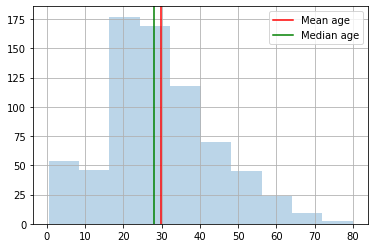

In [1307]:
tit_1 = fix_tab(tit)
col_1 = tit_1.columns

In [1308]:
k_2 = list(tit_1.columns[tit_1.columns != 'Survived'])

In [1309]:
w = []
for i in k_2:
    w.append(i)

In [1310]:
s_scaler = StandardScaler()
scaled_X = s_scaler.fit_transform(tit_1[w]) 
x_train, x_test, y_train, y_test = train_test_split(scaled_X, tit_1['Survived'].to_numpy())

In [1311]:
clf_0 = KNeighborsClassifier()
params = {
    'n_neighbors': [1,3,5,10,20,30,40],
    'weights': ['uniform', 'distance'],
    'p': [1,2,3,4,5]
}
c_0 = GridSearchCV(clf_0, 
                  param_grid=params, 
                  scoring='accuracy', 
                  cv=5, # делим на 5 частей
                  refit=True, # Выберет самую хорошую модель и применит на тестовуб
                  n_jobs=5,# сколько потоков считать
                  verbose=5)
c_0.fit(x_train, y_train)
c_0.best_params_, c_0.best_score_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


({'n_neighbors': 3, 'p': 3, 'weights': 'distance'}, 0.8023903041185052)

In [1312]:
clf_1 = LogisticRegression(max_iter=1000)
params = {'C':np.arange(0,1,.1)}
c_1 = GridSearchCV(clf_1,
                  param_grid=params,
                  scoring='accuracy', 
                  cv=5, # делим на 5 частей
                  refit=True, # Выберет самую хорошую модель и применит на тестовуб
                  n_jobs=5,# сколько потоков считать
                  verbose=5)
c_1.fit(x_train, y_train)
print("train acc:", accuracy_score(c_1.predict(x_train), y_train))
print("test acc:", accuracy_score(c_1.predict(x_test), y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
train acc: 0.7859281437125748
test acc: 0.7937219730941704


C:\Users\ryzhk\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.77847604 0.77250589 0.77399843 0.77250589 0.77250589
 0.77399843 0.77399843 0.77399843 0.77399843]
  warnings.warn(


In [1313]:
df = pd.DataFrame(c_1.cv_results_)
df[1:]['mean_test_score'].max()

0.7784760408483896

In [1314]:
clf_2 = SVC()
params = {'C':np.arange(0,1,0.1)}
c_2= GridSearchCV(clf_2,params,cv=5,refit=True,n_jobs=5,verbose=5)
c_2.fit(x_train, y_train)
c_2.best_params_, c_2.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ryzhk\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.78740882 0.7754573  0.77395354 0.77097969 0.77546852
 0.7754573  0.7784536  0.78143867 0.77994613]
  warnings.warn(


({'C': 0.1}, 0.7874088205588599)

In [1315]:
c_3 = LinearRegression()
c_3.fit(x_train, y_train)
print("train acc:", mean_squared_error(c_3.predict(x_train), y_train))
print("test acc:", mean_squared_error(c_3.predict(x_test), y_test))

train acc: 0.1441902674288449
test acc: 0.15422672774913385


In [1316]:
clf_4 = DecisionTreeClassifier()
params = {'max_depth':np.arange(1,10,1),
          'min_samples_split':np.arange(1,10,1)}
c_4 = GridSearchCV(clf_4,
                  param_grid=params,
                  scoring='accuracy', 
                  cv=5, # делим на 5 частей
                  refit=True, # Выберет самую хорошую модель и применит на тестовуб
                  n_jobs=5,# сколько потоков считать
                  verbose=5)
c_4.fit(x_train, y_train)
c_4.best_params_, c_4.best_score_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\ryzhk\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.7784536  0.7784536  0.7784536  0.7784536  0.7784536
 0.7784536  0.7784536  0.7784536         nan 0.7844013  0.7844013
 0.7844013  0.7844013  0.7844013  0.7844013  0.7844013  0.7844013
        nan 0.78894625 0.78894625 0.78894625 0.78894625 0.78894625
 0.78894625 0.78894625 0.78894625        nan 0.77985636 0.77985636
 0.77985636 0.7783526  0.7783526  0.77985636 0.77985636 0.7783526
        nan 0.79342386 0.7949164  0.79341264 0.79642015 0.7949164
 0.7949164  0.7919201  0.79642015        nan 0.79787903 0.80236786
 0.79335653 0.79336775 0.79937156 0.80237908 0.79938279 0.79038267
        nan 0.79790147 0.80087532 0.79639771 0.80085288 0.79637527
 0.79936034 0.8053866  0.79790147        nan 0.80540905 0.80241275
 0.80839412 0.80087532 0.79187521 0.7978678  0.79639771 0.79791269
        nan 0.80843901 0.80841656 0.81587925 0.81286051 0.

({'max_depth': 9, 'min_samples_split': 4}, 0.8158792503647178)

# Test

In [1317]:
tit2 = pd.read_csv('test.csv')
tit2

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


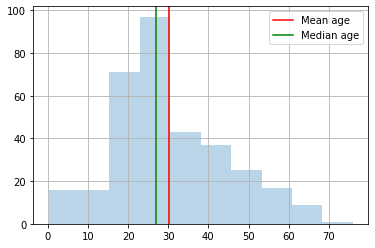

In [1318]:
tit_2 = fix_tab(tit2)
tit_2.drop(['PassengerId', 'Age', 'SibSp', 'Parch', 'Emb_Q', 'Pcl_2', 'Sib_2', 'Sib_3', 'Sib_4', 'Sib_5', 'Sib_8', 'Par_2', 'Par_3', 'Par_4', 'Par_5', 'Par_6'],inplace=True, axis = 1)

In [1319]:
col_2 = tit_2.columns
col_2

Index(['Sex', 'Fare', 'Emb_C', 'Emb_S', 'Pcl_1', 'Pcl_3', 'Sib_0', 'Sib_1',
       'Par_0', 'Par_1', 'Par_9'],
      dtype='object')

In [1320]:
col_3 = list(set(col_2) - set(col_1))

In [1321]:
tit_2.drop(col_3, axis=1, inplace=True)

In [1322]:
c_0.predict(tit_2)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [1323]:
c_1.predict(tit_2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [1324]:
c_2.predict(tit_2)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [1325]:
c_3.predict(tit_2)

array([0.18058955, 0.38353888, 0.28400307, 0.15776577, 0.45234481,
       0.16177407, 0.4107264 , 0.43004528, 0.42803388, 0.21067533,
       0.15230237, 0.42728963, 1.06585818, 0.37753975, 0.91556165,
       0.67028354, 0.30297568, 0.19644193, 0.3901303 , 0.42800395,
       0.72027081, 0.14976062, 0.69935006, 0.75944443, 2.3920186 ,
       0.20542081, 0.99528197, 0.19644193, 0.45935601, 0.24198834,
       0.37753975, 0.35322195, 0.47408653, 0.49457338, 0.70851314,
       0.19647186, 0.3849632 , 0.38932779, 0.16373368, 0.49861923,
       0.27169107, 0.43120886, 0.15197601, 0.51040775, 0.85413103,
       0.15251045, 0.50257491, 0.18002518, 1.06614292, 0.4347153 ,
       0.67562674, 0.34225433, 0.55534209, 2.28404263, 0.34614434,
       0.30601619, 0.15230237, 0.15055084, 0.21682219, 2.39214669,
       0.15230237, 0.28240866, 0.15126342, 0.41140906, 2.09694653,
       0.56741464, 0.41250787, 0.54415376, 0.49429109, 2.34755267,
       0.41158721, 0.15230237, 0.38407247, 0.4884714 , 2.02961

In [1326]:
c_4.predict(tit_2)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,